# Mesoscale structure analyses
First Figure:
This notebook goes through the steps of creating a stacked bar chart for connectome data. It pulls the modularity data and the synaptic weight data for oviIN_r's inputs. 

1. Finds the top connections to oviINr
2. Merges the modularity and synaptic weight data on the bodyId column
3. Groups the dataframe by celltype and module id number while adding up the weights if they need to
4. Table is pivoted so that the modules are the columns
5. Totals are added up of the celltypes to sort and check results
6. Stacked bar plot shows the module id that the celltypes are sorted into

Second Figure
- We wanted to see here wether the largest inputs were mainly in one module or if there was some pattern to the primacy of the largest inputs within their modules.

This was done by finding the rank of ovis to the Input celltypes (was oviIN their highest output)

Written by Rhessa Weber Langstaff

In [49]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from neuprint import Client
import matplotlib.patheffects as path_effects
import matplotlib as mpl
import bokeh
import bokeh.palettes

plt.rcParams["pdf.fonttype"] = 42
plt.rcParams["font.sans-serif"] = "Helvetica"

from neuprint import fetch_simple_connections, fetch_synapse_connections, NeuronCriteria as NC

auth_token_file = open("flybrain.auth.txt", 'r')
auth_token = next(auth_token_file).strip()
try:
    np_client = Client('neuprint.janelia.org', dataset='hemibrain:' + 'v1.2.1', token=auth_token)
except:
    np_client = None


# Body Ids of oviINs
oviINr= 423101189
oviINl= 485934965
# inputs to the oviINr
ovi_inputs = fetch_simple_connections(None, oviINr)
ovi_inputs

,bodyId_pre,bodyId_post,weight,type_pre,type_post,instance_pre,instance_post,conn_roiInfo
0,611015907,423101189,287,SMP176,oviIN,SMP176_R,oviIN_R,"{'INP': {'pre': 54, 'post': 53}, 'CRE(R)': {'p..."
1,5813087891,423101189,255,SMP544,oviIN,SMP544_R,oviIN_R,"{'LX(R)': {'pre': 66, 'post': 65}, 'LAL(R)': {..."
2,1598011458,423101189,243,LAL134,oviIN,LAL134_R,oviIN_R,"{'LX(R)': {'pre': 42, 'post': 42}, 'LAL(R)': {..."
3,5813022375,423101189,236,IB017,oviIN,IB017_R,oviIN_R,"{'SNP(R)': {'pre': 97, 'post': 97}, 'SMP(R)': ..."
4,448342846,423101189,225,CRE075,oviIN,CRE075_R,oviIN_R,"{'INP': {'pre': 199, 'post': 199}, 'CRE(R)': {..."
...,...,...,...,...,...,...,...,...
2519,5901221890,423101189,1,SLP422,oviIN,SLP422_R,oviIN_R,"{'SNP(R)': {'pre': 1, 'post': 1}, 'SMP(R)': {'..."
2520,5901226036,423101189,1,None,oviIN,None,oviIN_R,"{'SNP(R)': {'pre': 1, 'post': 1}, 'SMP(R)': {'..."
2521,5901230025,423101189,1,None,oviIN,None,oviIN_R,"{'VMNP': {'pre': 1, 'post': 1}, 'VES(R)': {'pr..."
2522,5901231318,423101189,1,None,oviIN,None,oviIN_R,"{'SNP(L)': {'pre': 1, 'post': 1}, 'SMP(L)': {'..."


In [50]:
# import modularity data and whole brain data
wbs = pd.read_csv('hemibrain/preprocessed-v1.2/preprocessed_nodes.csv', index_col=0)
mod = pd.read_csv('oviIN_sep10/preprocessed_inputs-v1.2.1/preprocessed_nodes.csv')
mod

,id,key,0.05,0.1,0.5,0.0,instance,celltype,pre,post,...,status,cropped,statusLabel,cellBodyFiber,somaRadius,somaLocation,roiInfo,notes,inputRois,outputRois
0,234630133,1,1,1,1,1,SMP184(PDL05)_L,SMP184,1075,2470,...,Traced,True,Leaves,NaN,NaN,NaN,"{'SNP(L)': {'pre': 153, 'post': 1758, 'downstr...",NaN,"['CRE(-ROB,-RUB)(R)', 'CRE(R)', 'INP', 'LAL(-G...","['CRE(-ROB,-RUB)(R)', 'CRE(R)', 'INP', 'LAL(-G..."
1,263674097,2,2,2,2,2,LHPD2a5_a_R,LHPD2a5_a,133,547,...,Traced,False,Roughly traced,PDL06,268.5,"[5386, 20096, 4080]","{'SNP(R)': {'pre': 121, 'post': 330, 'downstre...",NaN,"['CRE(-ROB,-RUB)(R)', 'CRE(R)', 'INP', 'LH(R)'...","['INP', 'LH(R)', 'SCL(R)', 'SIP(R)', 'SMP(R)',..."
2,266187480,3,3,3,3,3,SMP349_R,SMP349,190,854,...,Traced,False,Traced,PDM07,238.5,"[18808, 27714, 4256]","{'SNP(R)': {'pre': 190, 'post': 854, 'downstre...",NaN,"['SIP(R)', 'SLP(R)', 'SMP(R)', 'SNP(R)']","['SIP(R)', 'SLP(R)', 'SMP(R)', 'SNP(R)']"
3,266187559,4,3,3,4,3,SLP399_R,SLP399,216,749,...,Traced,False,Roughly traced,PDM07,290.5,"[17838, 26568, 3924]","{'SNP(R)': {'pre': 216, 'post': 744, 'downstre...",NaN,"['LH(R)', 'SLP(R)', 'SMP(R)', 'SNP(R)']","['SLP(R)', 'SMP(R)', 'SNP(R)']"
4,267214250,5,3,3,5,3,pC1b_R,pC1b,816,3187,...,Traced,False,Traced,PDM09,446.5,"[18931, 10896, 14728]","{'SNP(R)': {'pre': 547, 'post': 2474, 'downstr...",NaN,"['AOTU(R)', 'AVLP(R)', 'ICL(R)', 'INP', 'SCL(R...","['AVLP(R)', 'INP', 'SCL(R)', 'SIP(R)', 'SLP(R)..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2506,5901231318,2507,6,6,235,5,NaN,NaN,55,66,...,Traced,True,Leaves,NaN,NaN,NaN,"{'SNP(L)': {'pre': 55, 'post': 66, 'downstream...",NaN,"['SMP(L)', 'SNP(L)']","['SMP(L)', 'SNP(L)']"
2507,5901232053,2508,4,4,15,4,SMP272(PDL21)_L,SMP272,1064,1640,...,Traced,False,Roughly traced,NaN,NaN,NaN,"{'SNP(L)': {'pre': 464, 'post': 967, 'downstre...",NaN,"['CRE(-RUB)(L)', 'CRE(L)', 'INP', 'LAL(L)', 'L...","['CRE(-RUB)(L)', 'CRE(L)', 'INP', 'SCL(L)', 'S..."
2508,6400000773,2509,3,3,31,3,SMP411_R,SMP411,182,522,...,Traced,False,Roughly traced,PDM09,321.5,"[22433, 11755, 18464]","{'SNP(R)': {'pre': 180, 'post': 467, 'downstre...",NaN,"['INP', 'LH(R)', 'MB(+ACA)(R)', 'PLP(R)', 'SCL...","['MB(+ACA)(R)', 'PLP(R)', 'SIP(R)', 'SLP(R)', ..."
2509,7112622044,2510,7,7,77,6,LAL137(PVL05)_L,LAL137,1376,2087,...,Traced,False,Roughly traced,NaN,NaN,NaN,"{'SNP(R)': {'pre': 304, 'post': 130, 'downstre...",VeLC-(LC)(c)Sm(b),"['CRE(-ROB,-RUB)(R)', 'CRE(-RUB)(L)', 'CRE(L)'...","['CRE(-ROB,-RUB)(R)', 'CRE(-RUB)(L)', 'CRE(L)'..."


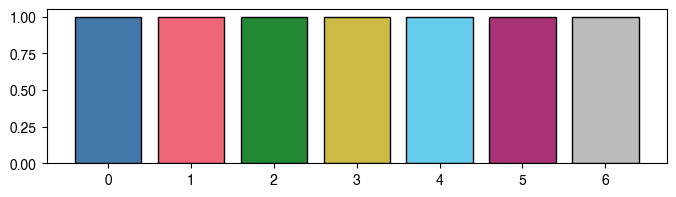

In [51]:
# Setting colors that coincide with module theme
import bokeh.palettes
colors = bokeh.palettes.tol['Bright'][7]

# Plotting the colors
plt.figure(figsize=(8,2))
for i, color in enumerate(colors):
    plt.bar(i, 1, color=color, edgecolor='black')

## Celltype Synapse countrs by Coarse Module

In [52]:
# inputs to oviINr and using only necessary columns
ovi_inputs = fetch_simple_connections(None,oviINr)
ovi_inputs_f = ovi_inputs[['bodyId_pre','type_pre','weight']]  

# Find the top 20 inputs to oviINr
ovi_inputs_filter = ovi_inputs[['type_pre','weight']]  

# collapse ovi_inputs by cell type and sort in descending order
ovi_inputs_top = ovi_inputs_filter.groupby('type_pre', as_index=False).sum().sort_values(by='weight', ascending=False,ignore_index=True)

# filter out cell types with less than 100 inputs
ovi_inputs_final = ovi_inputs_top[ovi_inputs_top['weight'] >= 100]

ovi_inputs_final.head()

,type_pre,weight
0,FS1A,892
1,IB017,370
2,SMP052,361
3,SMP176,299
4,FC2B,290


In [53]:
print('The length of the top connections to the oviIN are', len(ovi_inputs_final))

The length of the top connections to the oviIN are 33


In [54]:
# Merge weights onto ovi_in
ovi_in_merged = pd.merge(mod, ovi_inputs_f, how='left', left_on='id', right_on='bodyId_pre')

# Extract the columns we need
ovi_in_merged = ovi_in_merged[['celltype','0.0','weight']]

# Collapse the table by celltype and number in 0.0, adding up the weights
ovi_in_collapsed = ovi_in_merged.groupby(['celltype','0.0'], as_index=False).sum()

# Pivot the table so that the columns are the number of inputs and the rows are the cell types
ovi_in_pivot = ovi_in_collapsed.pivot(index='celltype', columns='0.0', values='weight')

# Filter celltypes for those in ovi_inputs_final
ovi_in_pivot = ovi_in_pivot[ovi_in_pivot.index.isin(ovi_inputs_final['type_pre'])]

# Add total number of inputs to each cell type
ovi_in_pivot['total'] = ovi_in_pivot.sum(axis=1)

# Sort by total number of inputs
ovi_in_pivot = ovi_in_pivot.sort_values(by='total', ascending=False)

# Drop total column so it doesn't get plotted
ovi_in_pivot = ovi_in_pivot.drop(columns='total')

# INdex to each column and set them to the column name
ovi_in_pivot.columns = range(0, ovi_in_pivot.shape[1])
# fill in NaN values with 0
ovi_in_pivot = ovi_in_pivot.fillna(0)
ovi_in_pivot.reset_index()

,celltype,0,1,2,3,4,5,6
0,FS1A,892.0,0.0,0.0,0.0,0.0,0.0,0.0
1,IB017,0.0,0.0,0.0,0.0,0.0,370.0,0.0
2,SMP052,0.0,0.0,0.0,322.0,39.0,0.0,0.0
3,SMP176,0.0,0.0,0.0,287.0,12.0,0.0,0.0
4,FC2B,290.0,0.0,0.0,0.0,0.0,0.0,0.0
5,SMP383,0.0,0.0,0.0,281.0,0.0,0.0,0.0
6,SMP544,0.0,0.0,0.0,0.0,4.0,0.0,255.0
7,LAL134,0.0,0.0,0.0,0.0,4.0,0.0,243.0
8,SMP550,0.0,0.0,147.0,0.0,87.0,0.0,0.0
9,CRE075,0.0,0.0,0.0,0.0,0.0,225.0,0.0


This table contains the synapse counts for each celltype in the cells. The synapse counts can be in different modules which are the columns. 

In [55]:
module1 = ovi_in_pivot[0]
module2 = ovi_in_pivot[1]
module3 = ovi_in_pivot[2]
module4 = ovi_in_pivot[3]
module5 = ovi_in_pivot[4]
module6 = ovi_in_pivot[5]
module7 = ovi_in_pivot[6]

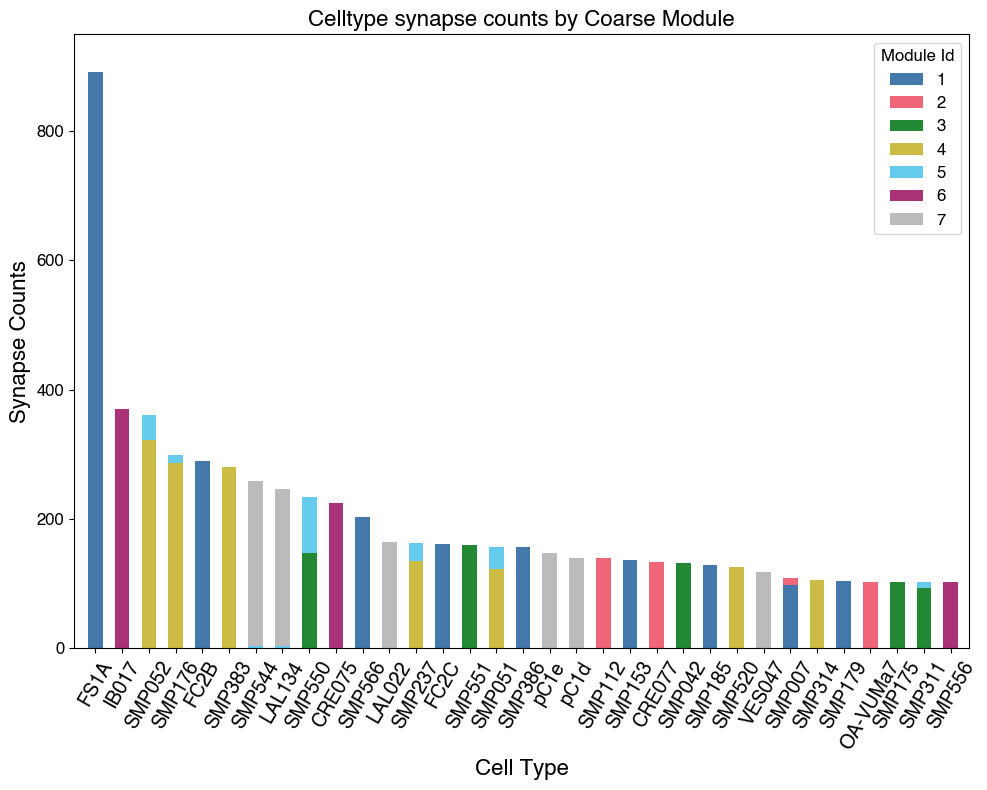

In [56]:
# Plot the stacked bar chart
fig, ax = plt.subplots(figsize=(10, 8))  
ax.bar(ovi_in_pivot.index, ovi_in_pivot[0], label='1', color=colors[0], width=0.55)
ax.bar(ovi_in_pivot.index, ovi_in_pivot[1], bottom=module1.values, label='2', color=colors[1], width=0.55)
ax.bar(ovi_in_pivot.index, ovi_in_pivot[2], bottom=np.add(module1, module2), label='3', color=colors[2], width=0.55)
ax.bar(ovi_in_pivot.index, ovi_in_pivot[3], bottom=np.add(np.add(module1, module2), module3), label='4', color=colors[3], width=0.55)
ax.bar(ovi_in_pivot.index, ovi_in_pivot[4], bottom=np.add(np.add(np.add(module1, module2), module3), module4), label='5', color=colors[4], width=0.55)
ax.bar(ovi_in_pivot.index, ovi_in_pivot[5], bottom=np.add(np.add(np.add(np.add(module1, module2), module3), module4), module5), label='6', color=colors[5], width=0.55)
ax.bar(ovi_in_pivot.index, ovi_in_pivot[6], bottom=np.add(np.add(np.add(np.add(np.add(module1, module2), module3), module4), module5), module6), label='7', color=colors[6], width=0.55)


plt.title('Celltype synapse counts by Coarse Module', fontsize=16)
plt.xlabel('Cell Type', fontsize=16)
plt.ylabel('Synapse Counts', fontsize=16)
# get rid of padding to left and right of xtcks
plt.xlim(-0.8, len(ovi_in_pivot.index)-0.3)

# make tick label text larger
plt.xticks(fontsize=14)
plt.yticks(fontsize=12)
plt.ylim(0, 950)
plt.legend(title='Module Id', fontsize=12, title_fontsize=12, loc='upper right')
plt.xticks(rotation=60, ha='center')
plt.tight_layout()
plt.show()

## Distribution of the rank of oviIN's inputs

In [57]:
# drop everything but the modularity data
mod = mod[['id','0.0', '0.05', '0.1', '0.5', 'celltype']]

# Only use neccessary columns and collapse by celltype in ascending order and the number in column '0.0 (drops None Here)
# if you want to keep None, use 'None" string intead 
ovi_inputs_new = ovi_inputs[['type_pre', 'weight']].groupby('type_pre',as_index=False).sum().sort_values(by='weight', ascending=False, ignore_index=True)

# Filter out the cells with less than 100 synapses
ovi_inputs_col = ovi_inputs_new[ovi_inputs_new['weight'] >= 100]

# merge the 0.0 modularity data onto the ovi_inputs
ovi_inputs_merged = ovi_inputs_col.merge(mod, left_on='type_pre', right_on = 'celltype', how='left')

# drop all the columns that are not needed
ovi_inputs_filtered = ovi_inputs_merged[['type_pre', 'weight', '0.0']]

# Collapse the data by type pre without summing weights (use majority vote in 0.0)
ovi_inputs_grouped = ovi_inputs_filtered.groupby('type_pre', as_index=False).agg(lambda x:x.value_counts().index[0])


In [58]:
# Edit cluster 5 instances (for new data)
ovi_inputs_grouped.loc[ovi_inputs_grouped['type_pre'] == 'SMP175', '0.0'] = 3
ovi_inputs_grouped.loc[ovi_inputs_grouped['type_pre'] == 'SMP311', '0.0'] = 3
ovi_inputs_grouped.loc[ovi_inputs_grouped['type_pre'] == 'SMP544', '0.0'] = 7
ovi_inputs_grouped.loc[ovi_inputs_grouped['type_pre'] == 'SMP052', '0.0'] = 4
ovi_inputs_grouped.loc[ovi_inputs_grouped['type_pre'] == 'SMP051', '0.0'] = 4

# Order by module in 0.0 column
ovi_inputs_final = ovi_inputs_grouped.sort_values(by='0.0', ascending=True, ignore_index=True)
ovi_inputs_final

,type_pre,weight,0.0
0,SMP007,109,1
1,FC2B,290,1
2,FC2C,161,1
3,FS1A,892,1
4,SMP566,203,1
5,SMP179,104,1
6,SMP185,129,1
7,SMP153,137,1
8,SMP386,156,1
9,CRE077,133,2


In [59]:
print('The length of the top connections to the oviIN are', len(ovi_inputs_final))

The length of the top connections to the oviIN are 33


In [60]:
testchunk = ovi_inputs_final.copy()# Copies dataframe to avoid SettingWithCopyWarning
# Add columns to testchunk
testchunk['out_to_ovis_weight'] = 0
testchunk['out_to_ovis_rank'] = 0

# iterate through each row in testchunk and fetch connections for each cell type in order to find out where oviIN ranks with each cell's outputs
for idx, row in testchunk.iterrows():
    # fetch outputs for each top input of oviIN
    i_outputs = fetch_simple_connections(row.type_pre,None)

    # grab only necessary columns
    i_outputs = i_outputs[['type_post','weight']]

    # collapse outputs by cell type, summing along weights, and sort in descending order
    i_outputs = i_outputs.groupby('type_post', as_index=False).sum().sort_values(by='weight', ascending=False,ignore_index=True)

    # grab the row where oviIN is. there will be 1 row for both oviINr and oviINl.
    thing = i_outputs[i_outputs['type_post'] == 'oviIN'].weight

    # add the weight and rank of oviIN in its partners outputs to the testchunk dataframe
    testchunk.loc[idx,'out_to_ovis_weight'] = thing.values[0]
    testchunk.loc[idx,'out_to_ovis_rank'] = thing.index.values[0]

In [61]:
# Assign colors to each module
testchunk['color'] = testchunk['0.0'].apply(lambda x: colors[x-1])

# Sorting 
testchunk_edit = testchunk.sort_values(by='0.0', ascending=True, ignore_index=True)

# Testchunk drop columns
testchunk_small = testchunk_edit[['type_pre', 'out_to_ovis_rank', 'color']]

# Pivot so that celltypes in the index, and oviIN ranks in the columns and 0.0 is a second level column
testchunk_pivot = testchunk_small.pivot(index='out_to_ovis_rank', columns=['type_pre', 'color'], values='out_to_ovis_rank')

# Replace any non-Nan values with the number 1
testchunk_pivot = testchunk_pivot.notnull().astype('int')

# replace any zeros with NaN
testchunk_pivot = testchunk_pivot.replace(0, np.nan)

# Add in a blank row after 7 for plotting purposes
testchunk_pivot.loc[10]= np.nan

# Sort the index
testchunk_pivot = testchunk_pivot.sort_index(ascending=True)

testchunk_pivot

type_pre,SMP007,FC2B,FC2C,FS1A,SMP566,SMP179,SMP185,SMP153,SMP386,CRE077,...,SMP176,SMP556,CRE075,IB017,SMP544,pC1d,LAL134,LAL022,VES047,pC1e
color,#4477AA,#4477AA,#4477AA,#4477AA,#4477AA,#4477AA,#4477AA,#4477AA,#4477AA,#EE6677,...,#CCBB44,#AA3377,#AA3377,#AA3377,#BBBBBB,#BBBBBB,#BBBBBB,#BBBBBB,#BBBBBB,#BBBBBB
out_to_ovis_rank,,,,,,,,,,,,,,,,,,,,,
0,1.0,NaN,NaN,1.0,1.0,1.0,NaN,1.0,1.0,NaN,...,NaN,NaN,NaN,1.0,1.0,NaN,1.0,NaN,1.0,1.0
1,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


/var/folders/db/q8_kwk2x73df8d997nrf14k1nfx1_b/T/ipykernel_86266/3603977915.py:28: MatplotlibDeprecationWarning: An artist whose label starts with an underscore was passed to legend(); such artists will no longer be ignored in the future.  To suppress this warning, explicitly filter out such artists, e.g. with `[art for art in artists if not art.get_label().startswith('_')]`.
  ax.legend(handles[33:], labels_final[-7:], loc='upper right', fontsize=16, title='Module Id', title_fontsize=16)


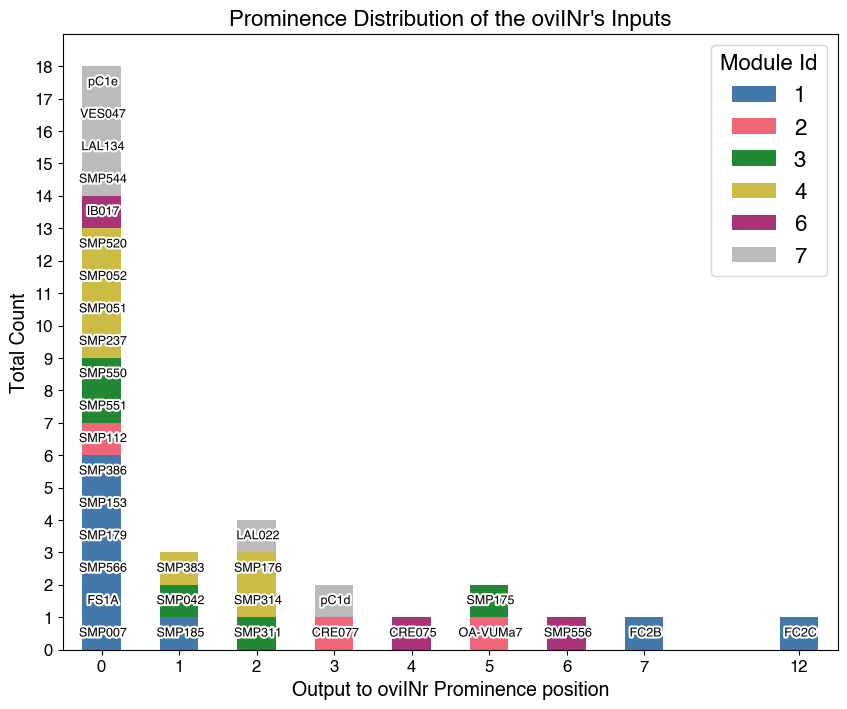

In [62]:
# Plotting the data
fig, ax = plt.subplots(figsize=(10, 8))
# stacked bar plot using 0.0 index as color group
testchunk_pivot.plot(kind='bar', stacked=True, ax=ax, color=testchunk_pivot.columns.get_level_values(1), label=None)


# generate labels for each stacked bar using the cell type names
labels_edit = testchunk_pivot.columns.get_level_values(0).to_list()

# annotate the stacked bar plot
for i in range(len(testchunk_pivot)):
    y = 0
    for j in range(len(testchunk_pivot.columns)):
        if testchunk_pivot.iloc[i,j] == 1:
            # annotate with black font and white outline
            ax.text(i+0.02, y + 0.5, labels_edit[j], ha='center', va='center', rotation=0, fontsize=9, color='black', path_effects=[path_effects.withStroke(linewidth=3, foreground='white')])
            y += 1

ax.legend().remove()

#make my own legend
for i, color in enumerate(colors):
    ax.bar(0, 0, color=color, label=labels_edit[i])

labels_final = labels_edit + [1,2,3, 4, "_", 6, 7]
# I only want to display the last five legend items
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[33:], labels_final[-7:], loc='upper right', fontsize=16, title='Module Id', title_fontsize=16)

plt.xticks(rotation=0,fontsize=12)
ax.set_yticks(np.linspace(0, 18, 19))
ax.set_yticklabels(np.linspace(0, 18, 19, dtype=int), fontsize=12)
ax.set_ylabel('Total Count', fontsize=14)
ax.set_xlabel('Output to oviINr Prominence position', fontsize=14)
ax.set_title("Prominence Distribution of the oviINr's Inputs", fontsize=16)
plt.ylim(0, 19)
xticks = ax.xaxis.get_major_ticks()
xticks[8].set_visible(False)

Here the 5th cluster neurons are filtered into their other cluster membership as they are most likely left side pairs

## Synaptic Input sites colored by Module Membership